In [2]:
# 首先加载必用的库
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('./Chinese-Word-Vectors/sgns.zhihu.bigram', 
                                          binary=False)


In [4]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['中国科学院大学'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['中国科学院大学']
print(cn_model)

词向量的长度为300


In [5]:
# 计算相似度
cn_model.similarity('橘子', '香蕉')

0.54952295619796865

In [ ]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['欺骗'], topn=10)

In [ ]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 小孩'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

In [ ]:
cn_model.most_similar(positive=['天气','晴'], negative=['老天爷'], topn=1)


In [ ]:
# 获得样本的索引，样本存放于两个文件夹中，
import os
pos_txts = os.listdir('./CompanyNewsData/pos')
neg_txts = os.listdir('./CompanyNewsData/neg')

In [ ]:
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)) )

In [ ]:
# 现在我们将所有的评价内容放置到一个list里

train_texts_orig = [] # 存储所有评价，每例评价为一条string

# 添加完所有样本之后，train_texts_orig为一个含有4000条文本的list
# 其中前7769条文本为正面评价，后7769条为负面评价

for i in range(len(pos_txts)):
    with open('./CompanyNewsData/pos/'+ pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(pos_txts)):
    with open('./CompanyNewsData/neg/' + neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [ ]:
len(train_texts_orig)

In [ ]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

In [ ]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [ ]:

# 获得所有tokens的长度# 获得所有to 
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [ ]:
# 平均tokens的长度
np.mean(num_tokens)

In [ ]:
# 最长的评价tokens的长度
np.max(num_tokens)

In [ ]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

In [ ]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [20]:
reverse = reverse_tokens(train_tokens[1])


In [21]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'成为具有中国情怀全球视野的人才不仅能肩负起建设祖国的使命而且能承担 世界为人类作贡献的责任“ 无以 非志无以成学”传授知识是教育的重要功能“要在增长知识见识上下功夫教育引导学生珍惜学习时光心无旁骛求知 增长见识丰富学识沿着求真理悟道理明事理的方向前进”在全国教育大会上习近平总书记的谆谆教导殷殷期许值得为人师者和莘莘学子铭记在心当今时代知识更新的节奏不断加快有学者曾根据放射性元素衰变的原理提出“知识半衰期”说法：一个专业人士的知识如果不更新在“半衰期”后基础知识仍可用但其他一半新知识却已落伍据测算1950年前的知识半衰期为50年21世纪知识的半衰期平均为32年IT高级工程师的仅为18年传统学人“书读完了”的感叹再也不会出现如今的学习没有完成时只有进行时还需保持加速度增长知识见识可以说是一辈子的功夫另一方面教育的普及出版的繁荣互联网的兴盛使得知识获取的成本大大下降“学好数理化”不再成为求知边界通识教育正不断打开知识视野因此若以知识宽度论今天学子可以完胜过去然而广度之外同样需要有深度 反能精读以致“韦编三绝”；诱惑少所以心无旁骛不断钻研将有限的注意力资源用到最有效的地方才会有“铁杵磨成针”的成就因此既要重视知识的宽度也要重视学习的深度在努力扩大知识半径的同时避免陷入平面化的“知识焦虑”落入浅尝辄止的学习路径既有知识的宽度又有知识的深度才能在积累知识的基础上形成卓越的见识当前许多领域深入发展创新的重要性愈发凸显芯片技术如何突破人工智能领域如何推进东西方文化如何更好交融这有赖于“博观而约取厚积而薄发”尽管传授高深知识的使命往往在高等教育但是培养钻研精神却需要从小抓起面对全球化竞争教育者需要引导学生摆脱简单的记诵在 上下功夫；关注知识的积累更注重思维的锤炼换句话说 好的教育既教会学生如何数清掉落的苹果更激发学生思考为何苹果是掉下来而 上天知识传承很重要见识的培育更关键在古汉语中“知”与“识”相连又有别 获取信息是第一层级；识是具备见解是更高层级由 方为智慧一方面正所谓“师父领进门修行在个人”注重把所学知识内化于心形成自己的见解才算得上学懂弄通；而另一方面具备 精的信息筛选力去伪存真的知识鉴别力把握时代大势的洞察力方能在信息爆炸的时代从容不迫从路径上说培养见识离不开课堂但也不能囿于课堂既需要言传更需要鼓励学生在敏于求知勤于学习敢于创新勇于实践的过程中去主动领悟与把握今天谈增长知

In [22]:
embedding_dim

300

In [23]:
# 只使用前20000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')
print(embedding_matrix)

[[-8.017840e-01 -1.653400e-01  3.050800e-02 ...  1.065250e-01
   5.534360e-01  4.366500e-01]
 [-6.517470e-01  5.359700e-01  3.402710e-01 ...  8.053990e-01
   1.045930e-01  1.936940e-01]
 [-4.123210e-01  2.282610e-01  2.071140e-01 ...  8.087770e-01
   5.675100e-02  4.523740e-01]
 ...
 [ 5.849840e-01  1.121180e-01 -6.938330e-01 ... -3.760570e-01
   1.203500e-01 -1.059511e+00]
 [ 1.511710e-01 -3.200000e-04 -3.885760e-01 ... -5.988550e-01
   4.273530e-01 -3.922630e-01]
 [-4.536090e-01 -1.813600e-02 -1.306600e-01 ... -6.608000e-02
   3.566680e-01  3.898050e-01]]


In [24]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum(cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [25]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

In [1]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')
print(train_pad)

NameError: name 'pad_sequences' is not defined

In [27]:
# 超出五万个词向量的词用0代替# 超出五万个词 
train_pad[ train_pad>=num_words ] = 0

In [28]:

# 可见padding之后前面的tokens全变成0，文本在最后面# 可见padd 
train_pad[13]

array([ 1649, 15574,     0, ...,   384,   148,   981], dtype=int32)

In [29]:
# 准备target向量，前2000样本为1，后2000为0# 准备targ 
train_target = np.concatenate( (np.ones(7769),np.zeros(7769)) )

In [30]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [31]:
#80%的样本用来训练，剩余20%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.2,
                                                    random_state=12)

In [32]:

# 查看训练样本，确认无误# 查看训练样本 
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

In [303]:
# 用LSTM对样本进行分类
model = Sequential()
print(num_words)

50000


In [154]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

ValueError: Fetch argument <tf.Variable 'embedding_2/embeddings:0' shape=(50000, 300) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("embedding_2/embeddings/Read/ReadVariableOp:0", shape=(50000, 300), dtype=float32) is not an element of this graph.)

In [ ]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

In [ ]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=0.02)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()

In [ ]:
# 建立一个权重的存储点
path_checkpoint = './model.h5'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [ ]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [129]:
# 定义callback函数# 定义call 
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

[0. 0. 0. ... 0. 1. 0.]


In [44]:



# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=5,
          batch_size=128,
          callbacks=callbacks)

Train on 11187 samples, validate on 1243 samples
Epoch 1/5
11187/11187 [==============================] - 1212s 108ms/step - loss: 0.0460 - acc: 0.9815 - val_loss: 0.0084 - val_acc: 0.9968

Epoch 00001: val_loss improved from inf to 0.00837, saving model to ./model.h5
Epoch 2/5
11187/11187 [==============================] - 1204s 108ms/step - loss: 0.0120 - acc: 0.9962 - val_loss: 0.0051 - val_acc: 0.9976

Epoch 00002: val_loss improved from 0.00837 to 0.00509, saving model to ./model.h5
Epoch 3/5
11187/11187 [==============================] - 1210s 108ms/step - loss: 0.0057 - acc: 0.9983 - val_loss: 0.0042 - val_acc: 0.9984

Epoch 00003: val_loss improved from 0.00509 to 0.00422, saving model to ./model.h5
Epoch 4/5
11187/11187 [==============================] - 1206s 108ms/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9984

Epoch 00004: val_loss did not improve from 0.00422

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 5/5


In [45]:
# 模型测试
result  =  model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

3108/3108 [==============================] - 431s 139ms/step
Accuracy:99.74%


In [46]:
def predict_sentiment(text):
    # print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('===========================是一例正面新闻==================','output=%.2f'%coef)
    else:
        print('===========================是一例负面新闻==================','output=%.2f'%coef)

In [47]:
# 模型测试
import os
testDir = "./CompanyNewsData/test/"
list = os.listdir(testDir) #列出文件夹下所有的目录与文件
for i in range(0,len(list)):
    print(list[i])
    file = open(testDir+list[i], 'r')
    # 读取文件内容
    content = file.read()
    # 将内容送入模型
    predict_sentiment(content)
    file.close()

租客入住自如后出现咳血症状 检测显示 甲醛超标一倍 承租人.txt
===========================是一例负面新闻================== output=0.00
租房变网贷还上央行征信 华融消费金融被指背后搭桥.txt
===========================是一例负面新闻================== output=0.00
作家做阅读理解为何不及格   中国文明网.txt
===========================是一例正面新闻================== output=1.00
走进生活 实现匠心传承   中国文明网.txt
===========================是一例正面新闻================== output=1.00
尊师重教关系到国家的未来      海外教育工作者热议习近平在全国教育大会上的重要讲话   中国文明网.txt
===========================是一例正面新闻================== output=1.00
租车公司失踪客户要不回万元押金 疑不符网约车新政 网约车.txt
===========================是一例正面新闻================== output=0.73
做新时代的坚定者奋进者搏击者   中国文明网.txt
===========================是一例正面新闻================== output=1.00
尊重是最好的医师节礼物   中国文明网.txt
===========================是一例正面新闻================== output=1.00
自如租客 甲醛检测结果可人为控制 操作空间很大.txt
===========================是一例负面新闻================== output=0.00
走进美术馆 做个文化深呼吸   中国文明网.txt
===========================是一例正面新闻================== output=1.00
租房贷受害者 我以为只是租了房 却莫名欠下一身债 租客.txt
============

In [48]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [49]:
y_actual = np.array(y_test)

In [50]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

In [51]:

# 输出所有错误分类的索引# 输出所有错误 
len(misclassified)
print(len(X_test))

3108


In [52]:
# 我们来找出错误分类的样本看看
idx=101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

的贪官 炮仗哥算了一下2018年7月 现货白银的 ：34元 60两就是3000克折合人民币 元也就是说贪污1 钱以上的贪官 直接砍头然而砍头也没能斩断贪官内心的贪欲就在广大 群众对朝廷的 叫好的同时 砍下的贪官脑袋也越来越 了洪武   25年头 砍但似乎没啥用啊贪官照 估计砍头太便宜 王八蛋了想到这里 决定直接升级刑罚经过 自创大明第一酷刑：“剥皮 草”这可比 创立的   削膝盖等酷刑残酷多了“剥皮 草”刑罚就是把那些贪官拉到每个府州县都设有的“ 庙”剥皮然后在皮囊内填充稻草和石灰将其放在处死贪官 的  旁边以警示继任之官员不要重蹈覆辙据统计 当政31年先后发起6次大规模 杀掉贪官污吏15 并卵就算剥皮大明朝还是有杀不完的贪官如果杀头剥皮能解决问题的话大明朝就不会成为中国历史上最腐败的王朝了 也就不会干掉多达15 的贪官了据说 每干掉 贪官后官场就会清廉一段时间；然后贪官再贪 再干掉 循环往复无止境也也许这就是封建王朝“人治”的天生缺陷3高管的焦虑症2018年春节 一上班估计还没拿到    总经理王亚军和南京公司总经理 就 交上了自己的 就时间而言王亚军的 甚至没能给 足够的时间寻找合适的 其掌管的整个战略团队不得不向CEO   直至新任 负责人到岗而在此之前 已经分别有副总裁 副总裁颜建国上海公司总经理 等相继离职公司高管频频离职对公司 造成的伤害  但背后的原因值得深思作为一家超过千亿的  同类企业均实行总部区域城市公司的三级管控模式而 则一直实行总部城市公司的二级管控模式这意味着 的权力全部是集中到集团重要审批均需集团拍板其他公司则把 区域让区域有更多的主动权从 实践的效果来看三级管控的效率明显高于二级管控在房地产这个特殊的行业里也更加有利于控制产品质量目前看来 进入城市超过33个二级管控难度也开始 这导致了 问题 集团精力有限管不过来导致决策效率低下二是因为管控半径过长地方问题各异集团难以深入了解 有效管理 的权力几乎全部高度集中在集团层面这也不难理解为何  城市总经理选择离职“对于职业经理人而言很重要的是发展平台如果没有良好的平台和空间大家都做得不开心”一家 城市总公开对媒体说  已经离职的前地区 曾对外界透露：项目团队面临最大的压力之一就是物业交付这也是公司高管非常焦虑的问题因为 的物业近年来在交付中经常会因为产品质量和品质不达标而伴随业主维权最夸张的是

In [53]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

In [54]:
# 读取数据库新闻数据并保存至文本文件中 python3 已将mySQLdb==》pymysql
# import pymysql
# import re
# # 打开数据库连接
# db = pymysql.connect("localhost", "root", "pass", "news", charset='utf8' )

# # 使用cursor()方法获取操作游标 
# cursor = db.cursor()
# selectsql = "select news_title,content from company_news_data"
# cursor.execute(selectsql.encode('utf-8'))
# data = cursor.fetchall() #所有
# for item in data:
#   # 写入文本文件 title+content
#     filtrate = re.compile(u'[^\u4E00-\u9FA5]')  # 过滤非中文
#     title = filtrate.sub(r' ', item[0])
#     fo = open('/home/lihanghang/tensorflow/NLP/CompanyNewsData/pos/'+title+'.txt', "ab+")
#     # 以二进制写入章节题目 需要转换为utf-8编码，否则会出现乱码
#     fo.write(item[1].encode('UTF-8'))
#     fo.close()
# print("############写入完毕#########")


# # 关闭数据库连接
# db.close()





In [ ]:
# 基于CNN进行情感分析
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5"
# 清空图
tf.reset_default_graph()
# 我在这里定义了5种filter，每种100个
filters_size = [2, 3, 4, 5, 6]
num_filters = 100
# 超参数
BATCH_SIZE = 128
EPOCHES = 50
LEARNING_RATE = 0.001
L2_LAMBDA = 10
KEEP_PROB = 0.8

In [ ]:
# X_train, X_test, y_train, y_test 
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    assert x.shape[0] == y.shape[0], print("error shape!")
    # shuffle
    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))

        x = x[shuffled_index]
        y = y[shuffled_index]
    
    # 统计共几个完整的batch
    n_batches = int(x.shape[0] / batch_size)
    
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]
    
        yield x_batch, y_batch

In [ ]:
static_embeddings = embedding_matrix
print(static_embeddings)
EMBEDDING_SIZE = embedding_dim
# 句子最大长度
SENTENCE_LIMIT_SIZE = max_tokens

In [ ]:
with tf.name_scope("cnn"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, max_tokens), name="inputs")
        targets = tf.placeholder(dtype=tf.int64, shape=[None], name="targets")
        y_one_hot = tf.one_hot( targets , 1 ) # 正负分类
        print(inputs)
    # embeddings
    with tf.name_scope("embeddings"):
        # embedding_matrixs = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrixs")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 添加channel维度
        embed_expanded = tf.expand_dims(embed, -1, name="embed_expand")
    
    # 用来存储max-pooling的结果
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            filter_shape = [filter_size, EMBEDDING_SIZE, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, SENTENCE_LIMIT_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    padding="VALID",
                                    name="max_pooling")
            pooled_outputs.append(max_pooling)
    
    # 统计所有的filter
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    # dropout
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, KEEP_PROB)
    
    # output
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 1), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(dropout, W), b)
        predictions = tf.nn.sigmoid(logits, name="predictions")
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_one_hot, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(predictions, 0.5), tf.float32), y_one_hot)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

In [ ]:
# 存储准确率
cnn_train_accuracy = []
cnn_test_accuracy = []

In [5]:
saver = tf.train.Saver()

NameError: name 'tf' is not defined

In [49]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    writer = tf.summary.FileWriter("./graphs/cnn", tf.get_default_graph())
    n_batches = int(X_train.shape[0] / BATCH_SIZE)
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(X_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: X_train, targets: y_train})
        train_acc = train_corrects / X_train.shape[0]
        cnn_train_accuracy.append(train_acc)
        
        test_corrects = sess.run(accuracy, feed_dict={inputs: X_test, targets: y_test})
        test_acc = test_corrects / X_test.shape[0]
        cnn_test_accuracy.append(test_acc)
        
        print("Training epoch: {}, Training loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                                total_loss / n_batches,
                                                                                                                train_acc,
                                                                                                               test_acc))
    
    saver.save(sess, "checkpoints/cnn")
    writer.close()

KeyboardInterrupt: 

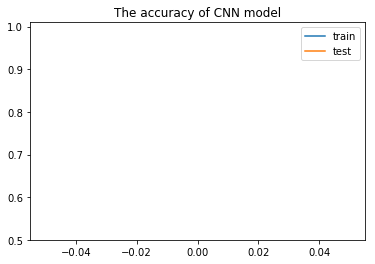

In [253]:
plt.plot(cnn_train_accuracy)
plt.plot(cnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of CNN model")
plt.legend(["train", "test"])

In [92]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/cnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The LSTM model accuracy on test set: {:.2f}%".format(100 * total_correct / x_test.shape[0]))

NotFoundError: checkpoints; No such file or directory

In [4]:
import socket
import sys
import threading
import json
import numpy as np
# from tag import train2
# nn=network.getNetWork()
# cnn = conv.main(False)
# 深度学习训练的神经网络,使用TensorFlow训练的神经网络模型，保存在文件中
nnservice = saver.restore(sess, "checkpoints/cnn")
def main():
    # 创建服务器套接字
    serversocket = socket.socket(socket.AF_INET,socket.SOCK_STREAM)
    # 获取本地主机名称
    host = socket.gethostname()
    # 设置一个端口
    port = 12345
    # 将套接字与本地主机和端口绑定
    serversocket.bind((host,port))
    # 设置监听最大连接数
    serversocket.listen(5)
    # 获取本地服务器的连接信息
    myaddr = serversocket.getsockname()
    print("服务器地址:%s"%str(myaddr))
    # 循环等待接受客户端信息
    while True:
        # 获取一个客户端连接
        clientsocket,addr = serversocket.accept()
        print("连接地址:%s" % str(addr))
        try:
            t = ServerThreading(clientsocket)#为每一个请求开启一个处理线程
            t.start()
            pass
        except Exception as identifier:
            print(identifier)
            pass
        pass
    serversocket.close()
    pass



class ServerThreading(threading.Thread):
    # words = text2vec.load_lexicon()
    def __init__(self,clientsocket,recvsize=1024*1024,encoding="utf-8"):
        threading.Thread.__init__(self)
        self._socket = clientsocket
        self._recvsize = recvsize
        self._encoding = encoding
        pass

    def run(self):
        print("开启线程.....")
        try:
            #接受数据
            msg = ''
            while True:
                # 读取recvsize个字节
                rec = self._socket.recv(self._recvsize)
                # 解码
                msg += rec.decode(self._encoding)
                # 文本接受是否完毕，因为python socket不能自己判断接收数据是否完毕，
                # 所以需要自定义协议标志数据接受完毕
                if msg.strip().endswith('over'):
                    msg=msg[:-4]
                    break
            # 解析json格式的数据
            re = json.loads(msg)
            # 调用神经网络模型处理请求
            res = nnservice.hand(re['content'])
            sendmsg = json.dumps(res)
            # 发送数据
            self._socket.send(("%s"%sendmsg).encode(self._encoding))
            pass
        except Exception as identifier:
            self._socket.send("500".encode(self._encoding))
            print(identifier)
            pass
        finally:
            self._socket.close() 
        print("任务结束.....")
        
        pass

    def __del__(self):
        
        pass
if __name__ == "__main__":
    main()

NameError: name 'saver' is not defined